# Error Stats vs Different seq_len

In [7]:
with open("../result.txt", "r") as file:
  lines = file.readlines()
mse, mae, rse, tg = [], [], [], []
for line in lines:
  if 'tg' in line:
    # print(line)
    tg.append(line.split('tg')[1].split('_')[0])
  if 'mse' in line:
    mse.append(round(float(line.split('mse:')[1].split(',')[0]), 3))
  if 'mae' in line:
    mae.append(round(float(line.split('mae:')[1].split(',')[0]), 3))
  if 'rse' in line:
    rse.append(round(float(line.split('rse:')[1].split(',')[0]), 3))

In [8]:
import pandas as pd
import numpy as np

idx = ['96', '192', '336', '720']
cols = list(dict.fromkeys(tg))

def plot_model_perf(error_type: str, error_list: list[float], idx_list: list[str]):
  x = np.reshape(error_list, (int(len(error_list)/len(idx)), len(idx_list))).T
  df = pd.DataFrame(x, columns=cols, index=idx_list)
  print(df)
  df.plot(style='--', marker='o', mfc='none', xlabel='Sequence Length', ylabel=error_type).legend(loc='upper right')

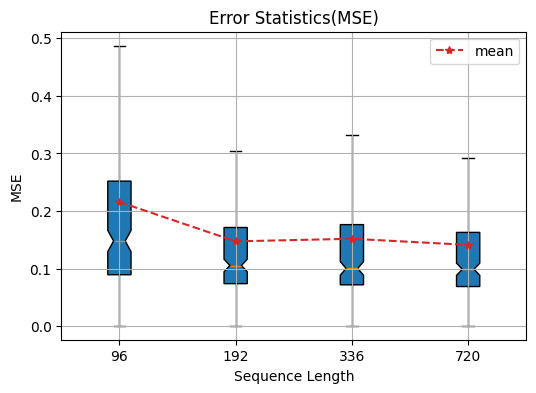

In [9]:
import matplotlib.pyplot as plt

def plot_box(error_type: str, error_list: list[float], idx_list: list[str]):
  x = np.reshape(error_list, (int(len(error_list)/len(idx_list)), len(idx_list)))
  x_mean = [np.mean(t) for t in x.T]

  fig, ax = plt.subplots(figsize=(6, 4))
  showfliers = False
  showmeans = False
  patch_artist = True
  positions = np.arange(1, len(idx_list)+1)
  width = 0.2
  widths = tuple([0.2] * len(idx_list))

  ax.boxplot(x, positions=positions, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)
  ax.plot(positions, x_mean, '--', color='tab:red', marker='*', label='mean', zorder=2)
  ax.grid()
  ax.legend()
  ax.set_xticklabels(idx_list)
  ax.set_title("Error Statistics({})".format(error_type))
  ax.set_xlabel('Sequence Length')
  ax.set_ylabel(error_type)

plot_box('MSE', mse, idx)

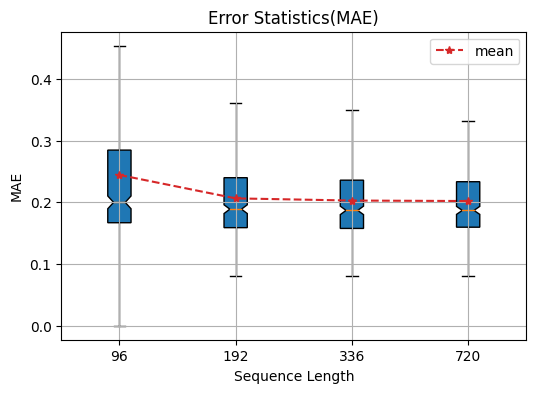

In [36]:
plot_box('MAE', mae, idx)

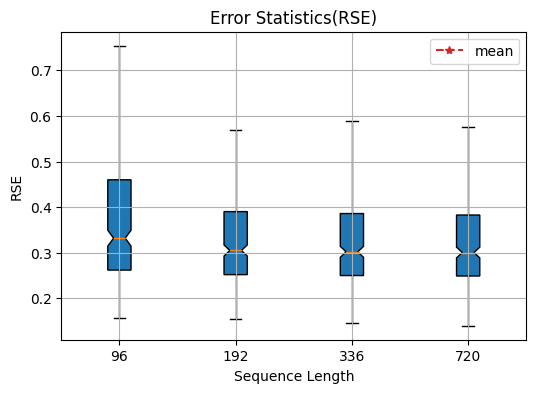

In [37]:
plot_box('RSE', rse, idx)

# Aggregate Models

Model(
  (Linear): Linear(in_features=720, out_features=24, bias=True)
) with 17304 parameters
tensor([[[4196.3628],
         [3836.9534],
         [3484.6255],
         [3171.6021],
         [2961.2351],
         [3080.6077],
         [2865.0957],
         [2750.0071],
         [2954.9578],
         [3556.8943],
         [4122.8159],
         [4962.8218],
         [5468.5239],
         [4938.0308],
         [4677.5400],
         [4344.7642],
         [4394.7690],
         [4906.1250],
         [5874.3003],
         [6647.4531],
         [6370.3950],
         [6120.6641],
         [5637.2134],
         [4994.0132]]], grad_fn=<PermuteBackward0>)


/mnt/zkpet/venv/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


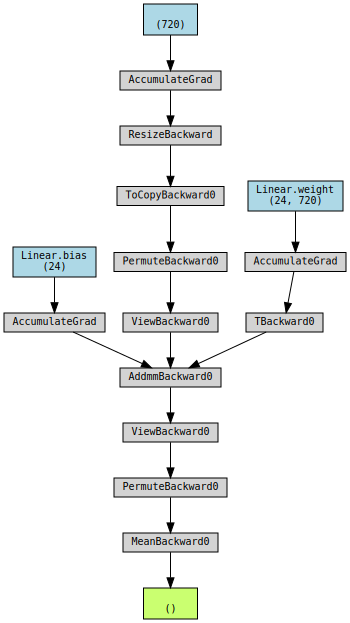

In [1]:
import torch
from torchviz import make_dot
import pandas as pd
import sys
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear


class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

model = 'Linear'
target = '40'
seq_len = 192
pred_len = 24

configs = Configs(seq_len, pred_len)
match model:
  case 'Linear':
    circuit = Linear(configs)
  case 'DLinear':
    circuit = DLinear(configs)
  case 'NLinear':
    circuit = NLinear(configs)

basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)

state_dict = torch.load(check_point_model)
circuit.load_state_dict(state_dict)

total_params = sum(
	param.numel() for param in circuit.parameters()
)

print(circuit, 'with {} parameters'.format(total_params))

df = pd.read_csv('../dataset/electricity.csv')
# Load the last seq_len entries data as input and converts to tensor
# x = 10*torch.rand(1,*[seq_len, 1], requires_grad=True)
x = torch.tensor(df[target][-seq_len:].values, requires_grad=True).resize(1, seq_len, 1).float()
# Flips the neural net into inference mode
circuit.eval()

y = circuit(x)
print(y)

# Visualize the trained model
# make_dot(y.mean(), params=dict(circuit.named_parameters()), show_attrs=True, show_saved=True)
make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img = make_dot(y.mean(), params=dict(circuit.named_parameters()))
# img.render(model, format="png")

In [19]:
import torch
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear
import warnings
warnings.filterwarnings("ignore")

class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

def plot_aggr():
    seq_lens = [96, 192, 336, 720]
    model = 'Linear'
    pred_len = 24
    pred_aggrs = []

    for seq_len in seq_lens:

      configs = Configs(seq_len, pred_len)
      match model:
        case 'Linear':
          circuit = Linear(configs)
        case 'DLinear':
          circuit = DLinear(configs)
        case 'NLinear':
          circuit = NLinear(configs)
          
      basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
      df = pd.read_csv('../dataset/electricity.csv')
      df_pred = df[['date']][-pred_len:]

      for target in range(320):
          check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
          state_dict = torch.load(check_point_model)
          circuit.load_state_dict(state_dict)
          # Load the last seq_len entries data as input and converts to tensor
          x = torch.tensor(df[str(target)][-(seq_len+pred_len):-pred_len].values, requires_grad=True).resize(1, seq_len, 1).float()
          # Flips the neural net into inference mode
          circuit.eval()
          y = circuit(x)
          df_pred[str(target)] = (y.detach().cpu().numpy()[0].flatten())

      df_pred['Agg_Prediction'] = df_pred.iloc[:, 1:].sum(axis=1)
      df_aggr = df[-pred_len:].set_index('date')
      df_aggr['Agg_GroundTruth'] = df_aggr.iloc[:, 1:-1].sum(axis=1)

      x_data = [dt.split(':')[0] for dt in df_aggr.index.values]
      y_pred = df_pred['Agg_Prediction'].values
      pred_aggrs.append(y_pred)
      y_truth = df_aggr['Agg_GroundTruth'].values

    fig, ax = plt.subplots(figsize=(6, 4))
    # Plot aggregated true load
    ax.plot(x_data, y_truth, label='GroundTruth')
    # Plot aggregated predicted load
    i = 0
    for y_pred in pred_aggrs:
        ax.plot(x_data, y_pred, '--', label='Prediction(seq_len={})'.format(seq_lens[i]))
        i+=1

    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    xticks_label = np.arange(0,24)
    ax.set(xlabel='Hours', xticklabels=xticks_label, ylabel='Aggregated Electricity Load (KWh)', title='Linear Aggregated Performance'.format(seq_len))
    ax.legend(bbox_to_anchor=(0.63,0.4))
    # plt.xticks(rotation=30, ha='right')
    plt.show()
    fig.savefig('aggr_perf.png')
    fig.savefig('aggr_perf.pdf')

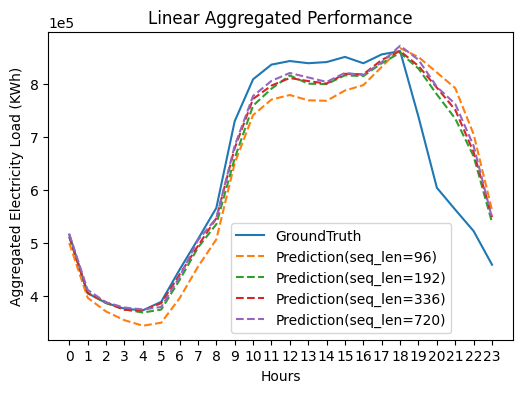

In [20]:
plot_aggr()

In [4]:
import pandas as pd
import numpy as np

data = "../dataset/electricity.csv"
df = pd.read_csv(data, parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S', index_col=['date'])

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Energy Demand')]

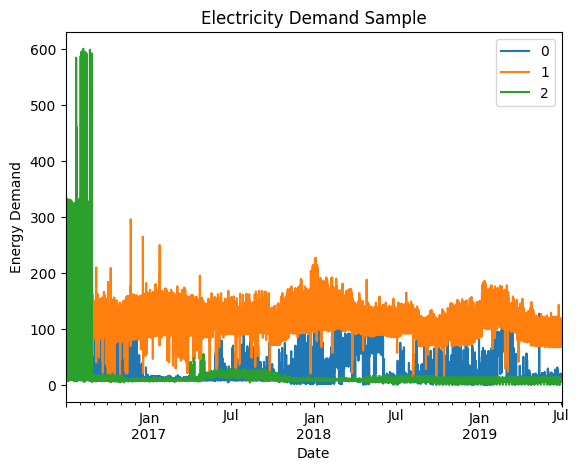

In [8]:
cols = df.columns.values
ax = df[cols[0:3]].plot(title='Electricity Demand Sample')
ax.set(xlabel='Date', ylabel='Energy Demand')

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


<Axes: xlabel='date'>

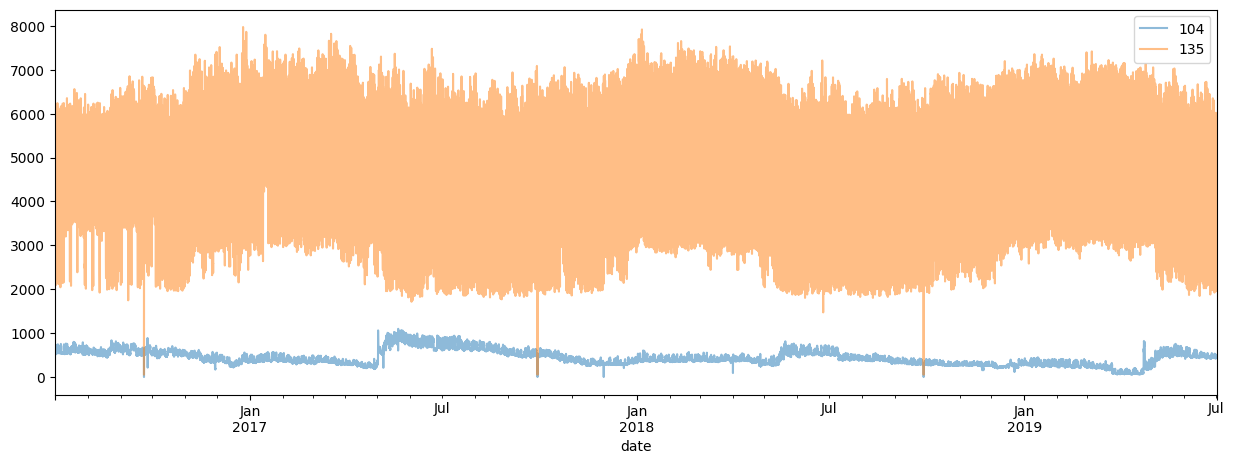

In [15]:
df[['104', '135']].plot(figsize = (15, 5), alpha = 0.5)

In [5]:
def decompose(df, column_name):
    """
    A function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend = 'freq')
    result_add = seasonal_decompose(df[column_name], model = 'additive', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return result_mul, result_add

In [10]:
df.loc[:, (df != 0).all()]

,104,127,129,130,135,136,137,138,139,142,...,272,273,274,275,276,277,279,280,282,283
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,403.0,263.0,76.0,105.0,2465.0,258.0,92.0,694.0,333.0,181.0,...,363.0,203.0,209.0,213.0,3199.0,720.0,640.0,1062.0,511.0,159.0
2016-07-01 03:00:00,544.0,262.0,69.0,108.0,2333.0,255.0,87.0,700.0,329.0,192.0,...,364.0,189.0,203.0,217.0,3078.0,706.0,610.0,1048.0,517.0,164.0
2016-07-01 04:00:00,528.0,261.0,67.0,111.0,2421.0,261.0,90.0,661.0,299.0,186.0,...,371.0,177.0,191.0,217.0,2967.0,642.0,613.0,1014.0,489.0,161.0
2016-07-01 05:00:00,553.0,262.0,69.0,104.0,2399.0,267.0,88.0,649.0,314.0,178.0,...,371.0,170.0,188.0,209.0,2907.0,696.0,601.0,987.0,511.0,166.0
2016-07-01 06:00:00,543.0,261.0,68.0,106.0,2300.0,258.0,79.0,652.0,299.0,184.0,...,349.0,178.0,190.0,215.0,3163.0,673.0,591.0,953.0,524.0,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01 21:00:00,449.0,180.0,369.0,125.0,4126.0,545.0,155.0,898.0,559.0,295.0,...,520.0,368.0,348.0,390.0,4762.0,1637.0,779.0,2231.0,705.0,371.0
2019-07-01 22:00:00,454.0,172.0,344.0,119.0,2850.0,464.0,118.0,609.0,453.0,177.0,...,384.0,242.0,223.0,274.0,3150.0,1236.0,581.0,945.0,665.0,185.0
2019-07-01 23:00:00,444.0,168.0,240.0,101.0,2674.0,335.0,119.0,516.0,419.0,179.0,...,389.0,233.0,204.0,254.0,3261.0,1156.0,458.0,965.0,639.0,178.0


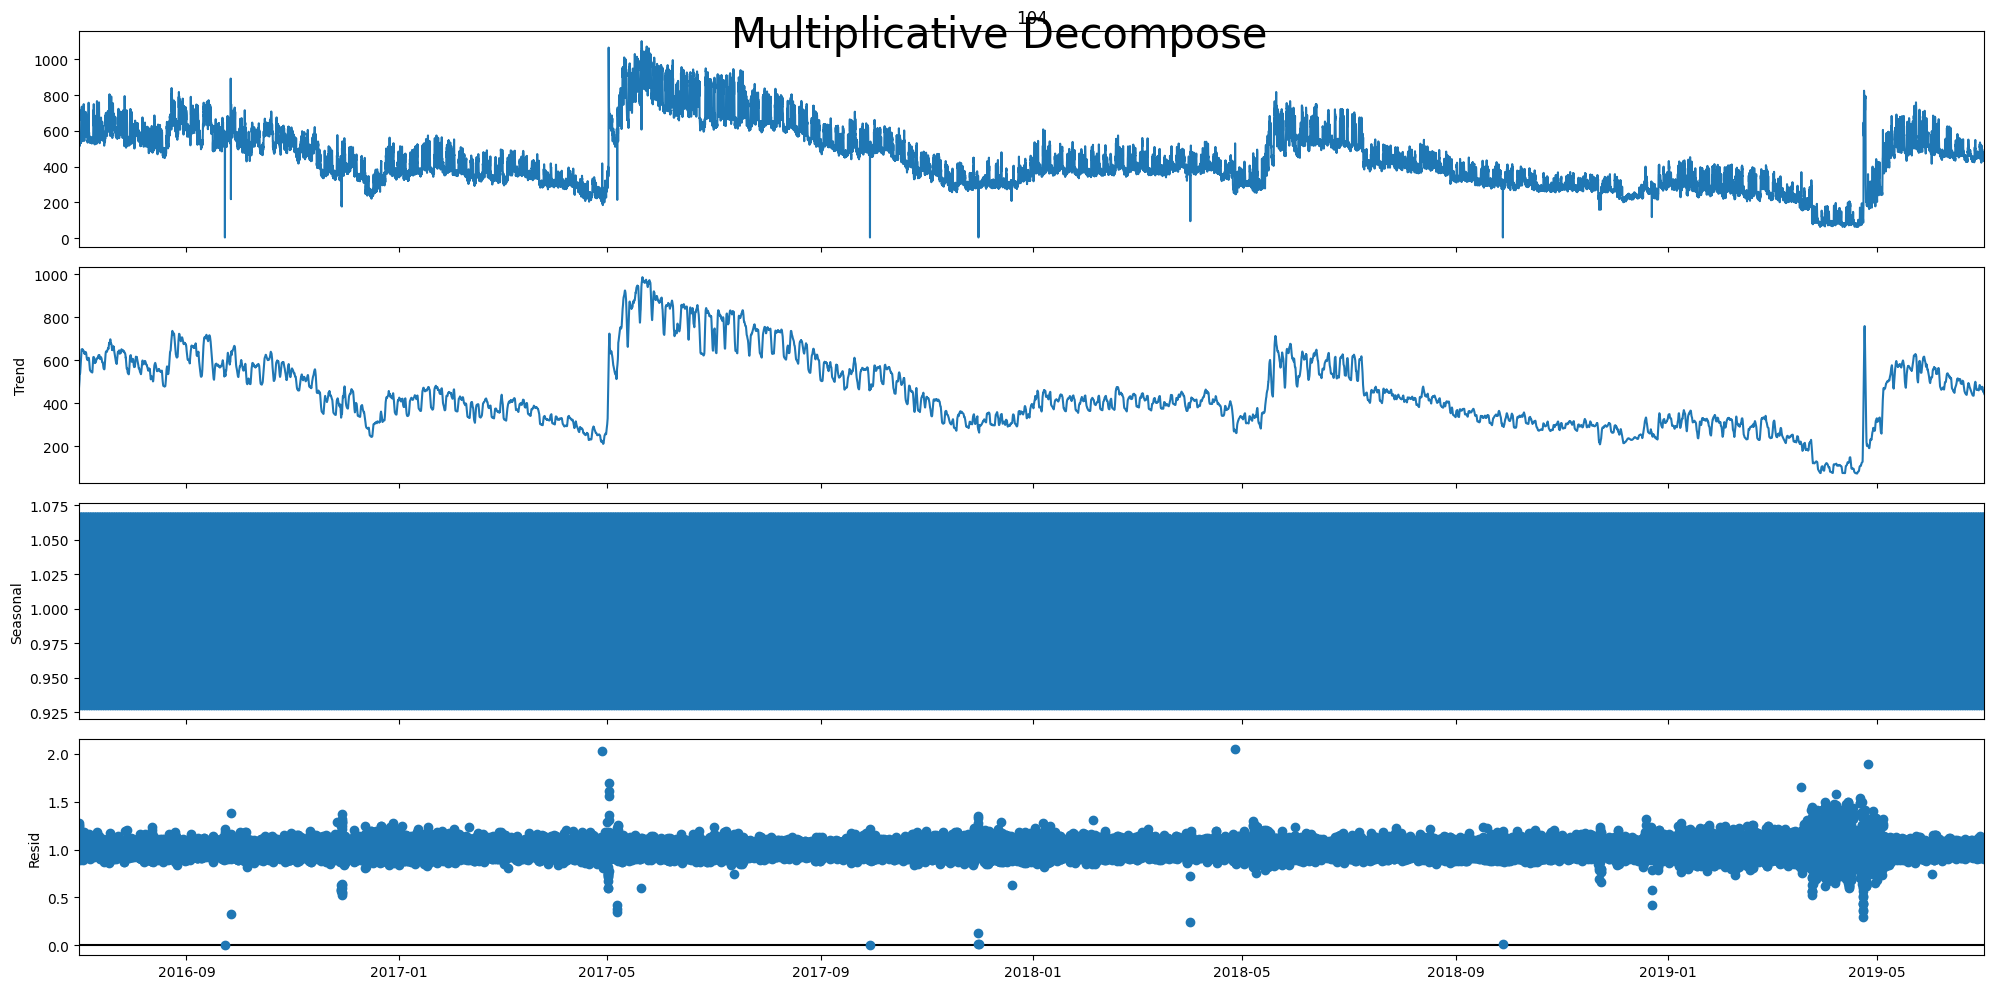

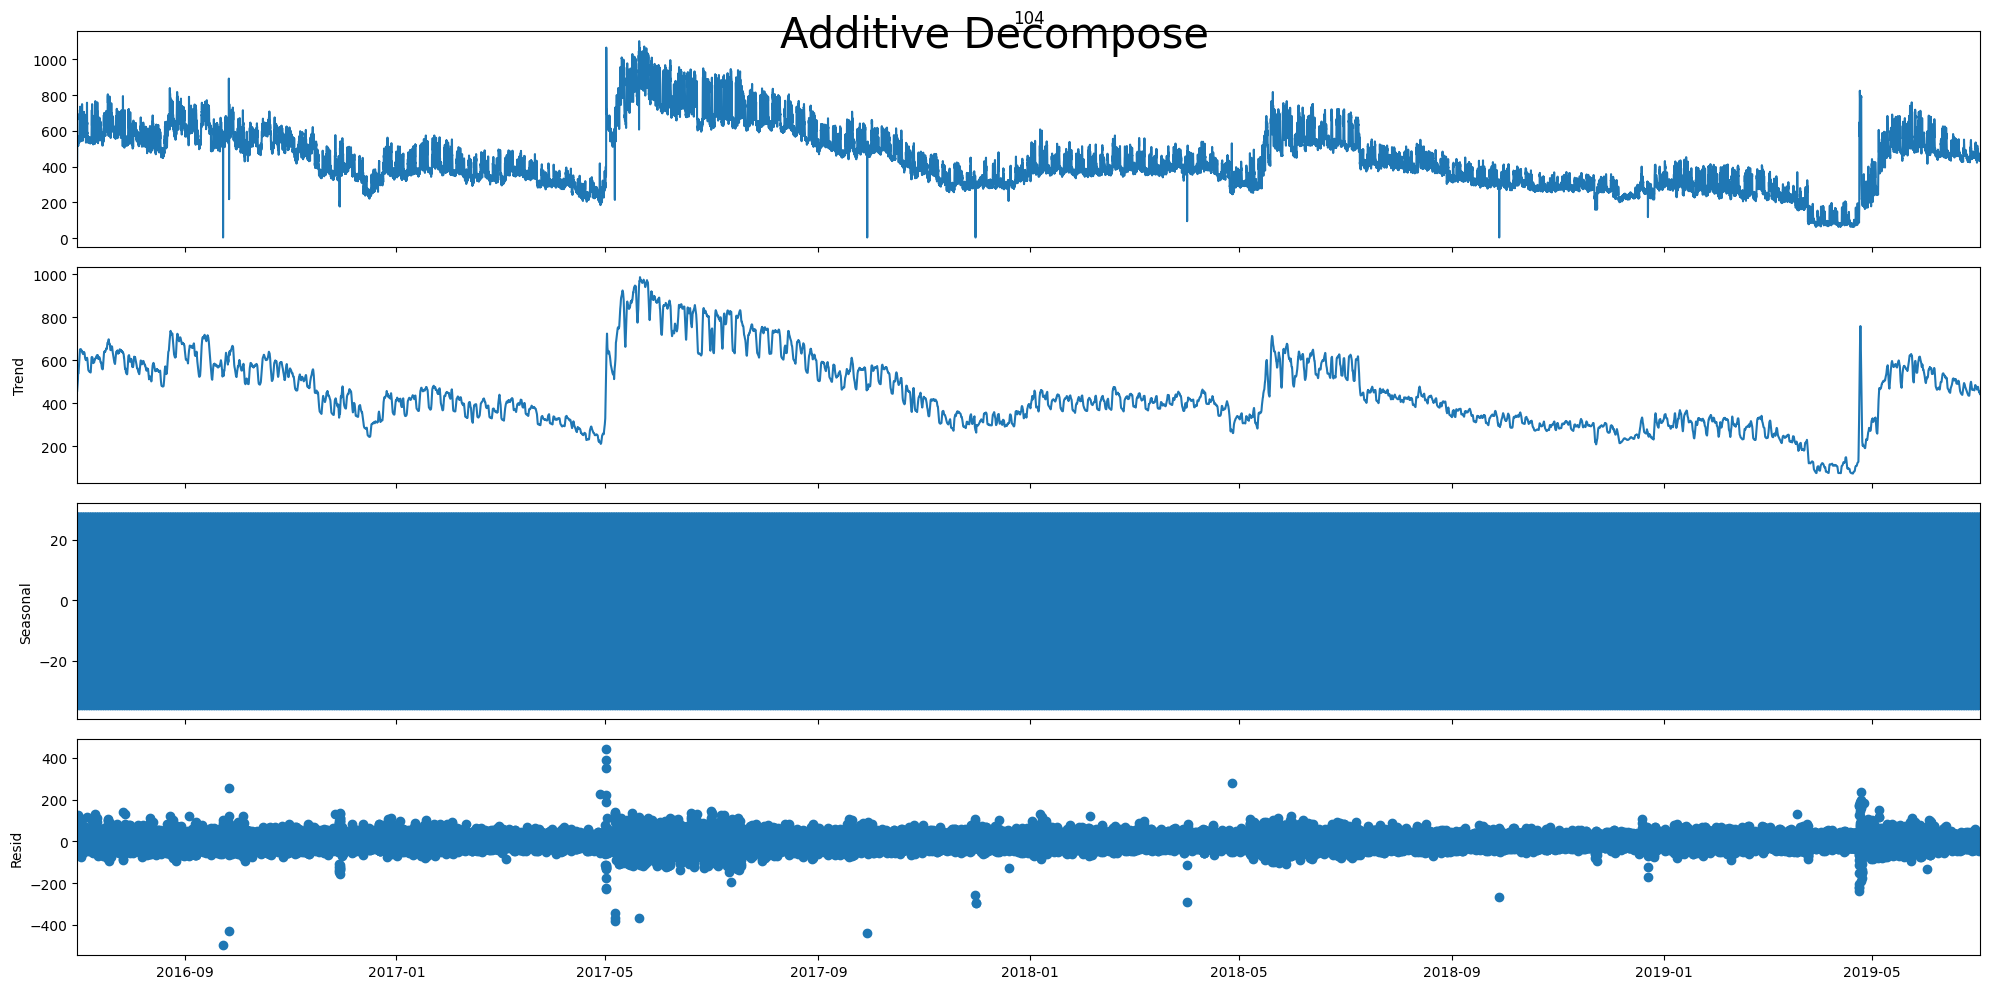

In [17]:
result_mul, result_add = decompose(df, '104')

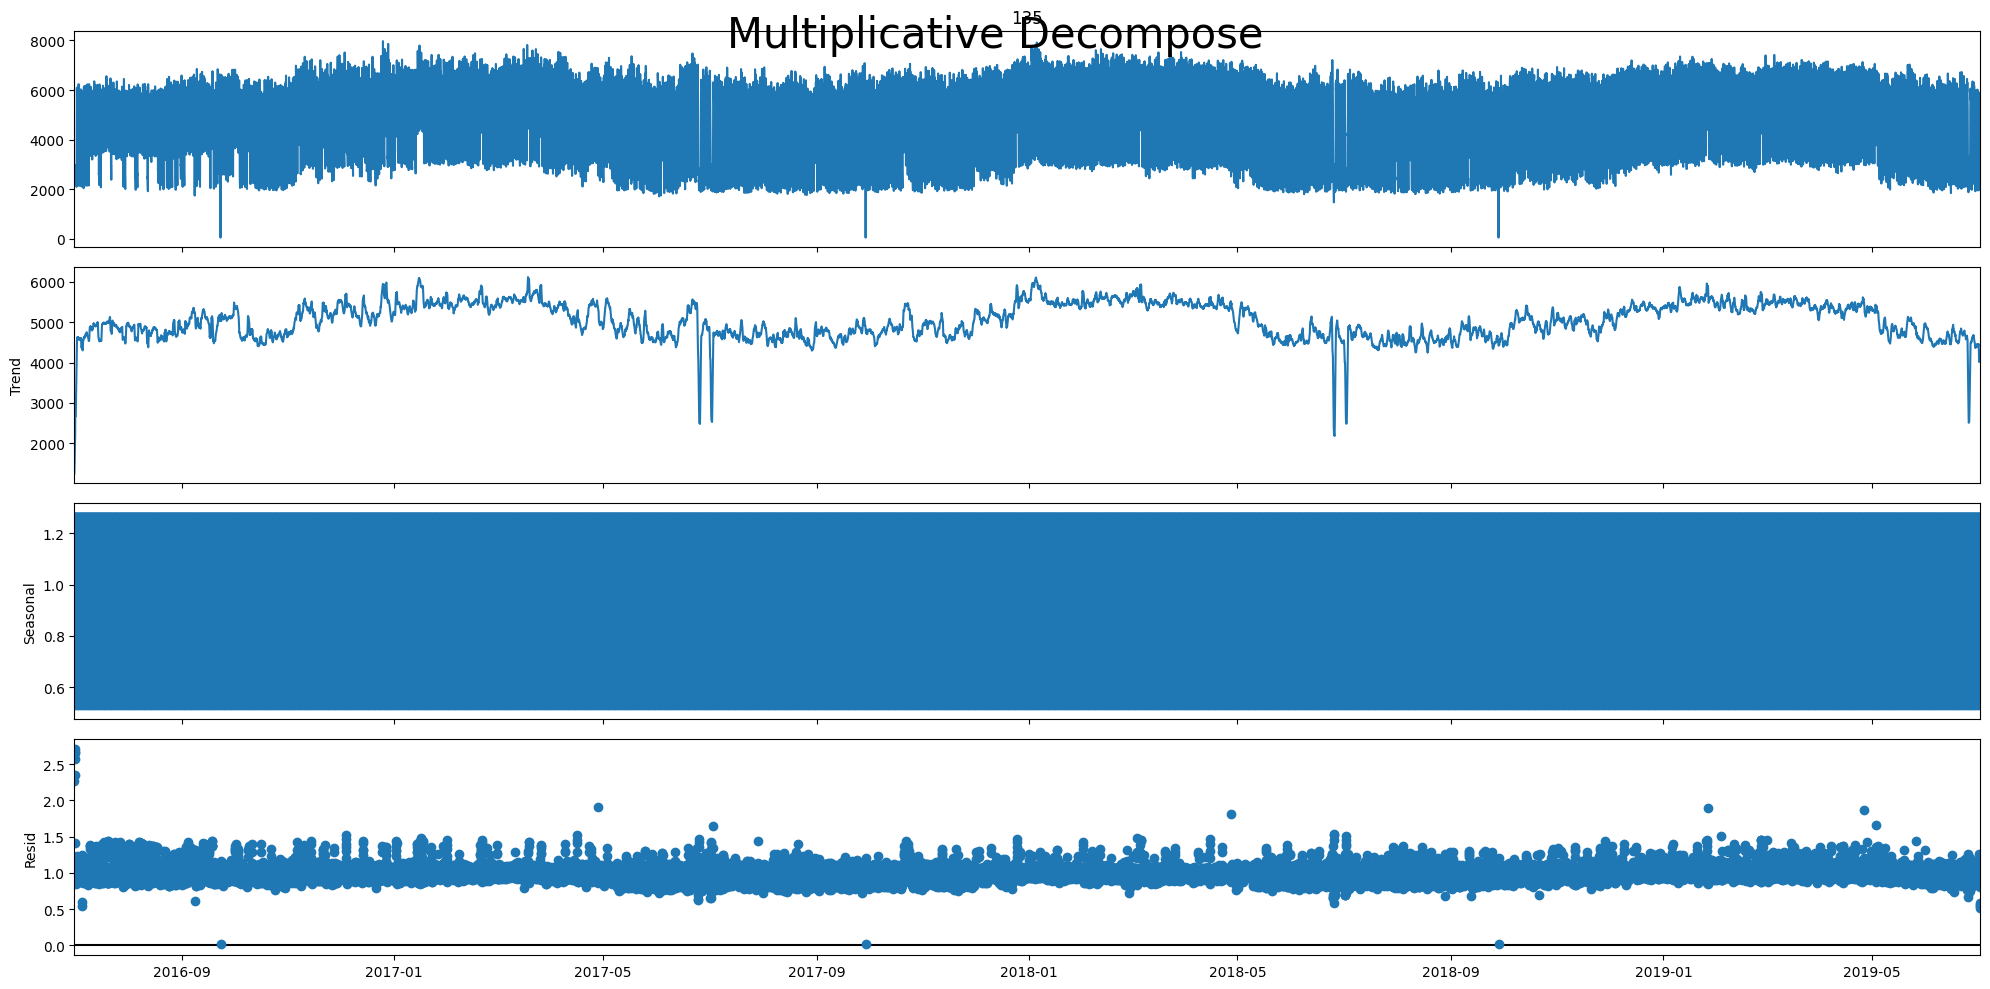

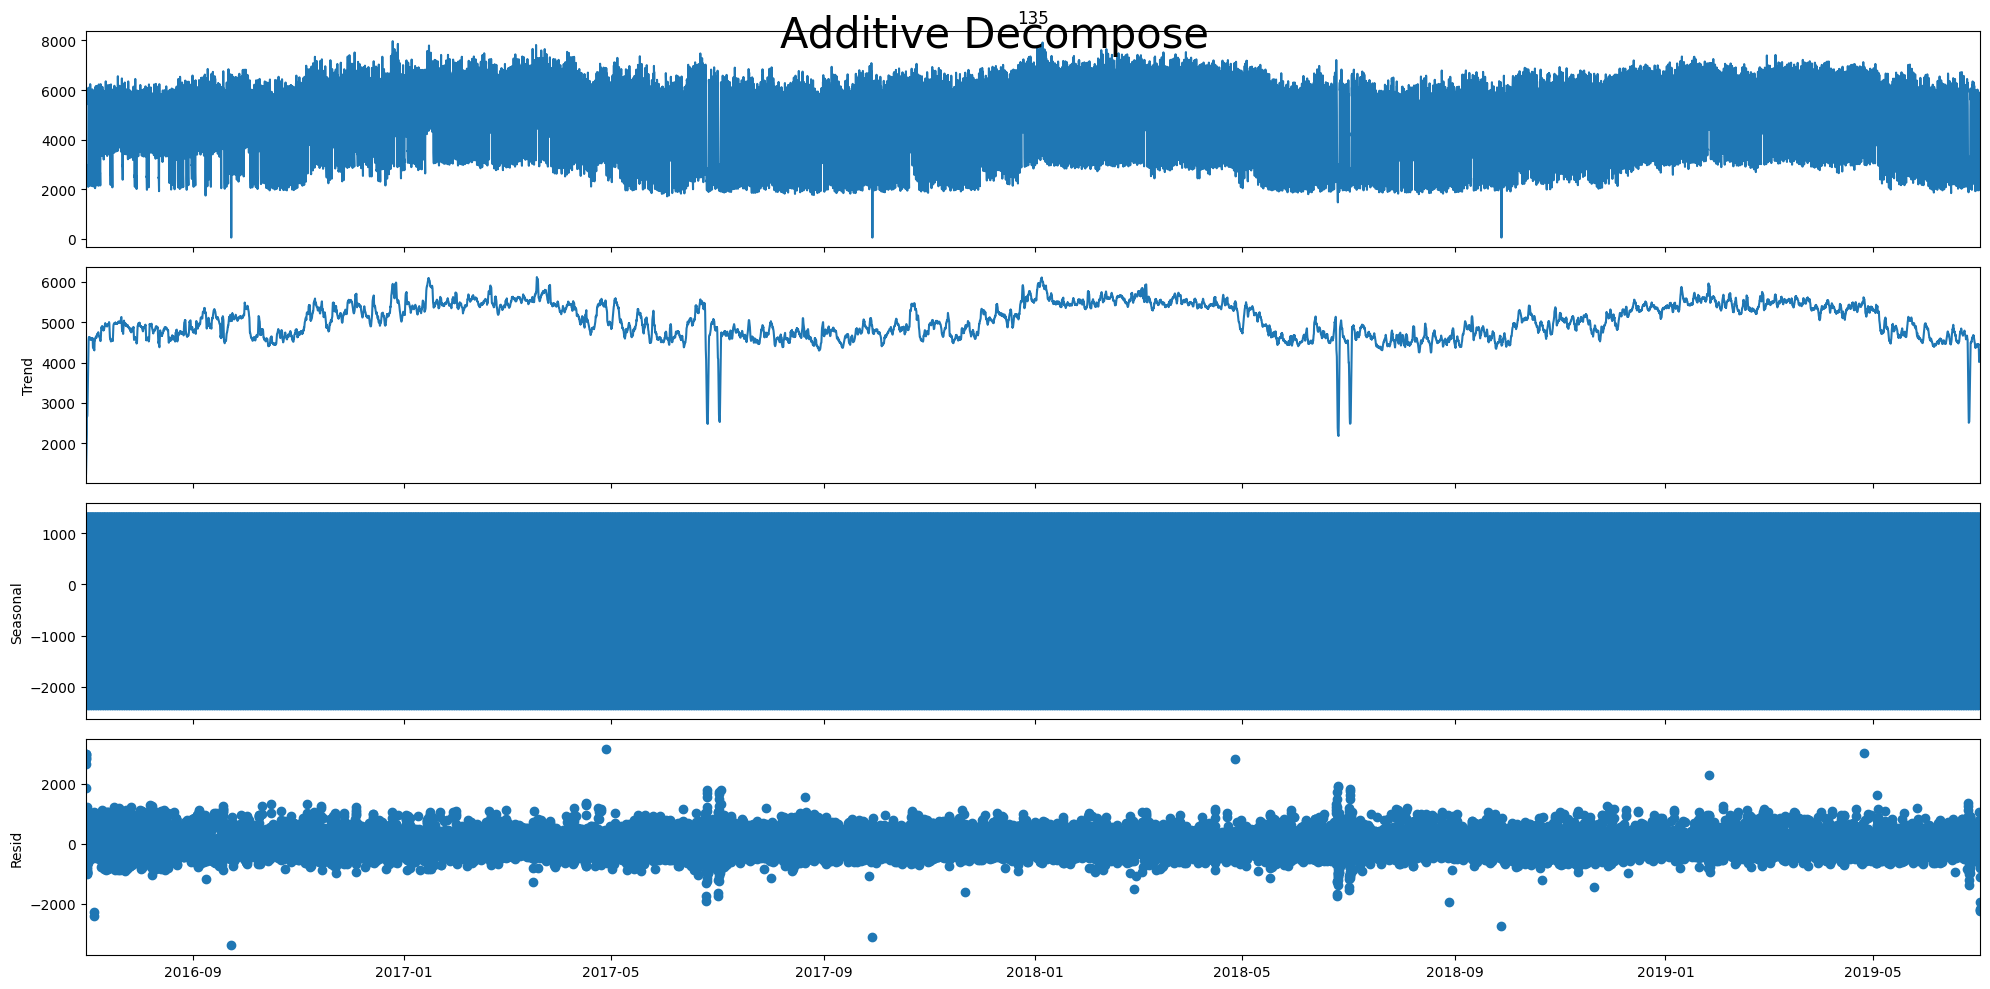

In [16]:
result_mul, result_add = decompose(df, '135')

# Centralized ZKML Performance Profile

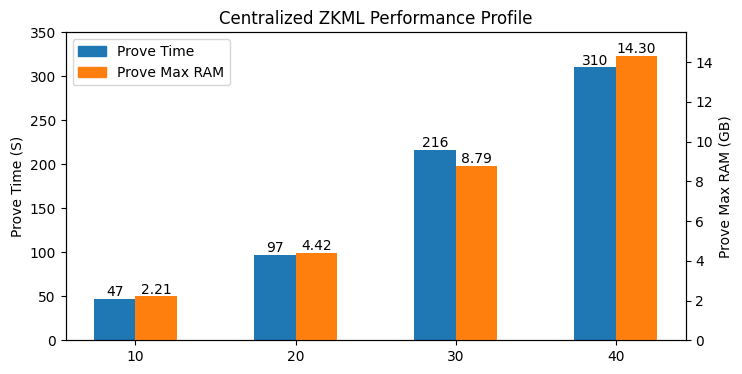

In [73]:
import numpy as np

num_homes = np.array([10, 20, 30, 40])
prove_times = [47, 97, 216, 310]
max_mems = np.array([2258, 4523, 8998, 14642]) / 1024

fig, ax = plt.subplots(figsize=(8, 4))
width=2.6
lns1 = ax.bar(x=num_homes-width/2, height=prove_times, width=width, color='tab:blue', label='Prove Time')
ax.set(ylabel='Prove Time (S)', title='Centralized ZKML Performance Profile')
ax.bar_label(lns1, fmt='{:,.0f}')
ax.set_ylim([0, 350])

ax1 = ax.twinx() 
lns2 = ax1.bar(num_homes+width/2, max_mems, width=width, color='tab:orange', label='Prove Max RAM')
ax1.set_xticks(ticks=num_homes)
ax1.set(xlabel='Num of Homes', ylabel='Prove Max RAM (GB)')
ax1.bar_label(lns2, fmt='{:,.2f}')
ax1.set_ylim([0, 15.5])


colors = {'Prove Time':'tab:blue', 'Prove Max RAM':'tab:orange'}
labels = list(['Prove Time', 'Prove Max RAM'])
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()
fig.savefig('cent_perf.png')

# Decentralized ZKML Performance Profile

In [16]:
import os
import pandas as pd

seq_len = 192
pred_len = 24
model = "Linear"
node_num = 320
# df = pd.read_csv('../dataset/electricity.csv')

percent_cpu = []
prove_time = []
prove_max_ram = []

for target in range(node_num):
  target = str(target)
  basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'
  basepath = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)
  perf_log = os.path.join(basepath, "perf.txt")

  with open(perf_log) as f:
    log = f.readlines()
    cpu = int(log[3].split(': ')[1].split('%')[0]) # cpu in percent
    percent_cpu.append(cpu)
    time = float(log[4].split(':')[-1]) # time in seconds
    prove_time.append(time)
    ram = round(int(log[9].split(': ')[1]) / 1024, 2) # ram in megabytes
    prove_max_ram.append(ram)

# Percent of CPU

# Prove time

# Prove max RAM


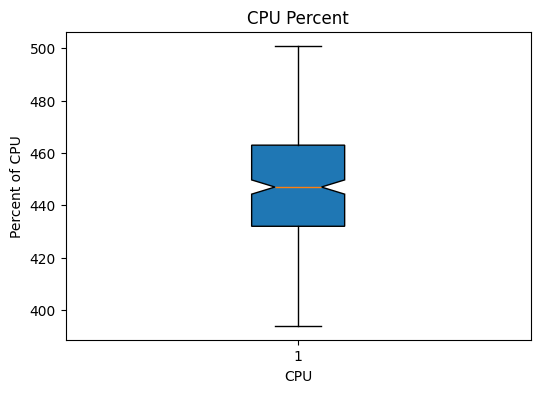

In [13]:
import matplotlib.pyplot as plt
idx_list = ['Percent of CPU', 'Prove Time (S)', 'Prove Max RAM(MB)']

fig, ax = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
width = 0.2
widths = tuple([0.2] * 1)
ax.boxplot(percent_cpu, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)

# ax.set_xticklabels(idx_list)
ax.set_title("CPU Percent")
ax.set_xlabel('CPU')
ax.set_ylabel(idx_list[0])
plt.show()

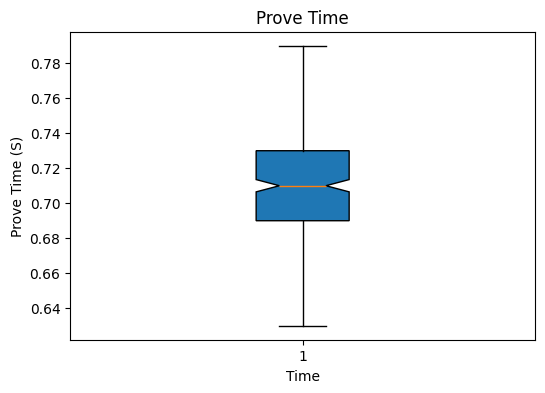

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
width = 0.2
widths = tuple([0.2] * 1)
ax.boxplot(prove_time, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)

# ax.set_xticklabels(idx_list)
ax.set_title("Prove Time")
ax.set_xlabel('Time')
ax.set_ylabel(idx_list[1])
plt.show()

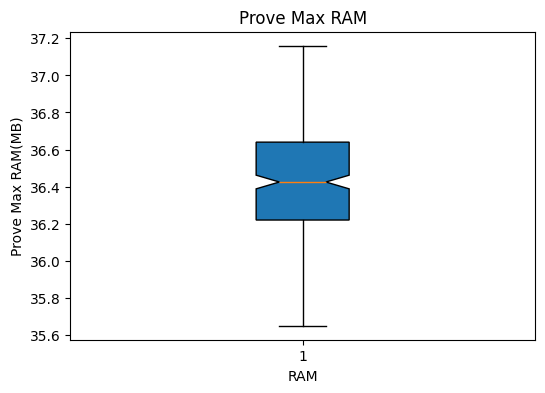

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
width = 0.2
widths = tuple([0.2] * 1)
ax.boxplot(prove_max_ram, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)

# ax.set_xticklabels(idx_list)
ax.set_title("Prove Max RAM")
ax.set_xlabel('RAM')
ax.set_ylabel(idx_list[2])
plt.show()

In [ ]:
# Proof time

# Numerical Fidelity

In [24]:
log_file = "../log.txt"
res = []
with open(log_file) as f:
  log_lines = f.readlines()
  key_words = 'proof took '
  for line in log_lines:
    if key_words in line:
      res.append(float(line.strip().split(key_words)[1]))  
print(res)


[0.645, 0.616, 0.586, 0.638, 0.6, 0.651, 0.659, 0.651, 0.625, 0.611, 0.577, 0.561, 0.607, 0.624, 0.692, 0.653, 0.638, 0.621, 0.663, 0.64, 0.624, 0.583, 0.662, 0.631, 0.609, 0.671, 0.676, 0.597, 0.632, 0.619, 0.623, 0.622, 0.629, 0.614, 0.729, 0.634, 0.606, 0.591, 0.612, 0.646, 0.607, 0.617, 0.611, 0.614, 0.619, 0.663, 0.649, 0.62, 0.575, 0.597, 0.611, 0.594, 0.642, 0.672, 0.633, 0.646, 0.626, 0.604, 0.628, 0.585, 0.651, 0.653, 0.617, 0.651, 0.677, 0.647, 0.632, 0.587, 0.67, 0.631, 0.647, 0.606, 0.636, 0.664, 0.639, 0.625, 0.617, 0.641, 0.641, 0.615, 0.617, 0.588, 0.641, 0.681, 0.632, 0.653, 0.619, 0.645, 0.673, 0.644, 0.623, 0.652, 0.65, 0.636, 0.619, 0.625, 0.647, 0.651, 0.642, 0.66, 0.651, 0.67, 0.674, 0.627, 0.637, 0.618, 0.611, 0.646, 0.627, 0.628, 0.631, 0.572, 0.653, 0.627, 0.614, 0.662, 0.653, 0.622, 0.617, 0.626, 0.65, 0.665, 0.639, 0.662, 0.638, 0.599, 0.644, 0.643, 0.664, 0.695, 0.69, 0.67, 0.605, 0.632, 0.604, 0.667, 1.13, 0.735, 0.637, 0.589, 0.666, 0.66, 0.629, 0.661, 0.68

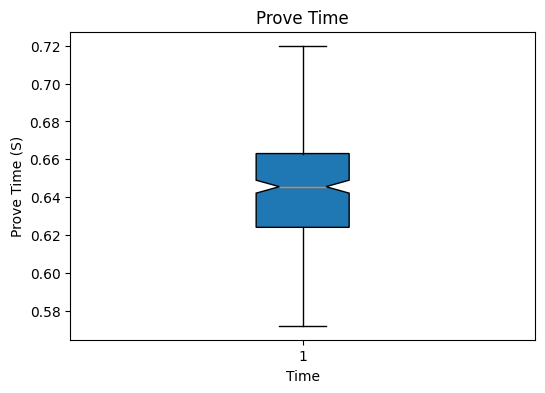

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
showfliers = False
showmeans = False
patch_artist = True
width = 0.2
widths = tuple([0.2] * 1)
ax.boxplot(res, sym='k+', notch=1, showfliers=showfliers, zorder=1, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="tab:blue"), widths=widths)

# ax.set_xticklabels(idx_list)
ax.set_title("Prove Time")
ax.set_xlabel('Time')
ax.set_ylabel(idx_list[1])
plt.show()

In [26]:
import numpy as np

np.mean(res)

0.652390625

In [27]:
np.mean(prove_time)

0.715625